In [18]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import argparse
import os
import unidecode
import string
import random
import time
import math
import torch

from tqdm import tqdm

In [20]:
class Args():
    def __init__(self):
        self.filename = 'filename'
        self.model = "gru"
        self.n_epochs = 2000
        self.print_every = 100
        self.hidden_size = 100
        self.n_layers = 2
        self.learning_rate = 0.01
        self.chunk_len = 200
        self.batch_size = 100
        self.shuffle = True
        self.cuda = False

In [21]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model="gru", n_layers=1):
        super(CharRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def forward2(self, input, hidden):
        encoded = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(encoded.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

In [22]:
# Reading and un-unicode-encoding data

all_characters = string.printable
n_characters = len(all_characters)

def read_file(filename):
    file = unidecode.unidecode(open(filename).read())
    return file, len(file)

# Turning a string into a tensor

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue
    return tensor

# Readable time elapsed

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [23]:
def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=False):
    hidden = decoder.init_hidden(1)
    prime_input = Variable(char_tensor(prime_str).unsqueeze(0))

    if cuda:
        hidden = hidden.cuda()
        prime_input = prime_input.cuda()
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)
        
    inp = prime_input[:,-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = Variable(char_tensor(predicted_char).unsqueeze(0))
        if cuda:
            inp = inp.cuda()

    return predicted

In [24]:

def random_training_set(chunk_len, batch_size):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    for bi in range(batch_size):
        start_index = random.randint(0, file_len - chunk_len)
        end_index = start_index + chunk_len + 1
        chunk = file[start_index:end_index]
        inp[bi] = char_tensor(chunk[:-1])
        target[bi] = char_tensor(chunk[1:])
    inp = Variable(inp)
    target = Variable(target)
    if args.cuda:
        inp = inp.cuda()
        target = target.cuda()
    return inp, target

def train(inp, target):
    hidden = decoder.init_hidden(args.batch_size)
    if args.cuda:
        hidden = hidden.cuda()
    decoder.zero_grad()
    loss = 0

    for c in range(args.chunk_len):
        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(args.batch_size, -1), target[:,c])

    loss.backward()
    decoder_optimizer.step()
    # print("test: ", loss.item())

    return loss.item() / args.chunk_len

def save():
    save_filename = os.path.splitext(os.path.basename(args.filename))[0] + '.pt'
    torch.save(decoder, save_filename)
    print('Saved as %s' % save_filename)


In [25]:
args = Args()
args.filename = 'shakespeare.txt'

if torch.cuda.is_available():
    args.cuda = True

if args.cuda:
    print("Using CUDA")

file, file_len = read_file(args.filename)

Using CUDA


In [26]:

# Initialize models and start training

decoder = CharRNN(
    n_characters,
    args.hidden_size,
    n_characters,
    model=args.model,
    n_layers=args.n_layers,
)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()

if args.cuda:
    decoder.cuda()

start = time.time()
all_losses = []
loss_avg = 0

try:
    print("Training for %d epochs..." % args.n_epochs)
    for epoch in tqdm(range(1, args.n_epochs + 1)):
        loss = train(*random_training_set(args.chunk_len, args.batch_size))
        loss_avg += loss
        all_losses.append(math.exp(loss))

        if epoch % args.print_every == 0:
            print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / args.n_epochs * 100, loss))
            print(generate(decoder, 'Wh', 100, cuda=args.cuda), '\n')

    print("Saving...")
    save()

except KeyboardInterrupt:
    print("Saving before quit...")
    save()

Training for 2000 epochs...


  5%|▌         | 100/2000 [00:46<16:37,  1.90it/s]

 46s (100 5%) 1.7562]
Whing him thereges, my hame the that gronighs to dives?

Perving and than not the dilfeds; I tae be I  



 10%|█         | 200/2000 [01:26<13:48,  2.17it/s]

 26s (200 10%) 1.5643]
Wherences duman me,
That much good he sweed should fortune
To our fear to what a if my near'd of way,
 



 15%|█▌        | 300/2000 [02:05<10:44,  2.64it/s]

 5s (300 15%) 1.5270]
Wher hath with messerile.
A dancunter-we have not so shall thee that hath not it,
Dive they mother to  



 20%|██        | 400/2000 [02:44<10:14,  2.61it/s]

 44s (400 20%) 1.4704]
Whild,
First kill sents than a present.

Pedants,
The place it of my prince are there?

DUKE OF YORK:
 



 25%|██▌       | 500/2000 [03:23<09:40,  2.58it/s]

 22s (500 25%) 1.4440]
Whift me of my life.

GLOUCESTER:
Ay, I very will blood in hath he bear
ston'd your dived many worshal 



 30%|███       | 600/2000 [04:01<08:49,  2.64it/s]

 1s (600 30%) 1.4231]
Where will bless and percear.

GREMIO:
And he quench his Soldect to princes we are nothing
persman, th 



 35%|███▌      | 700/2000 [04:41<11:25,  1.90it/s]

 41s (700 35%) 1.4035]
What bless with grave and man!
Brother goodly secret by my irest of head
The terreter and your king, o 



 40%|████      | 800/2000 [05:20<08:18,  2.41it/s]

 20s (800 40%) 1.3979]
Why and lies,
Though drew them best all the pecrice his scare?

ANGELO:
Which may well dares to for yo 



 45%|████▌     | 900/2000 [05:59<07:13,  2.54it/s]

 59s (900 45%) 1.3753]
Why at the secret when the tongue
With the city that that you have go sancill to kill,
And murder the  



 50%|█████     | 1000/2000 [06:38<06:23,  2.60it/s]

 38s (1000 50%) 1.4100]
What was full.

SEBORTON:
Marry, sir; let's so blood on your mistake
For you shall see the sad to her  



 55%|█████▌    | 1100/2000 [07:17<05:48,  2.58it/s]

 17s (1100 55%) 1.4004]
Whethem and stand and house,
And their precedant his tribune come, sir.

BAPTISTA:
Ay, come, trenclini 



 60%|██████    | 1200/2000 [07:56<05:06,  2.61it/s]

 56s (1200 60%) 1.3861]
What, yet will vengely.

First Cotide:
There, stunges not to thy loved and discontented the since
Hark 



 65%|██████▌   | 1300/2000 [08:35<04:33,  2.55it/s]

 35s (1300 65%) 1.3700]
Where are away:
Thy time is thy feel his dear her despire,
For what then the instakine early
That be w 



 70%|███████   | 1400/2000 [09:16<04:55,  2.03it/s]

 16s (1400 70%) 1.3559]
Which enjoy, but will say,
has I thou prove me further.

Weig:
Now his idle your inknost; he,
Whenced  



 75%|███████▌  | 1500/2000 [09:56<03:23,  2.45it/s]

 56s (1500 75%) 1.3413]
Where's thee?

PETRUCHIO:
What thou love my tender long how to visage you,
Which may be company should 



 80%|████████  | 1600/2000 [10:36<02:39,  2.51it/s]

 36s (1600 80%) 1.3957]
Wher come shall come to be doubt
Spoked breath of this leave thy love with me
To as so company the Duk 



 85%|████████▌ | 1700/2000 [11:15<01:54,  2.62it/s]

 15s (1700 85%) 1.3653]
Where with the when I have,
Drawn that hath she be soldiers to beseech of the lady for England.

YORK: 



 90%|█████████ | 1800/2000 [11:54<01:16,  2.63it/s]

 54s (1800 90%) 1.3854]
When it she were it of it which have broke that I shall stand thee.

KATHARINA:
Thou hast your son, he 



 95%|█████████▌| 1900/2000 [12:34<00:48,  2.07it/s]

 33s (1900 95%) 1.3523]
Where's a gone; but do no pleasing still defend them be thou art thou banish.

LUCIO:
Yet, well do you 



100%|██████████| 2000/2000 [13:13<00:00,  2.52it/s]

 13s (2000 100%) 1.3631]
Which is young when thou know not, or sea
Is this poor send them this be then,
To the made a worses.

 

Saving...
Saved as shakespeare.pt


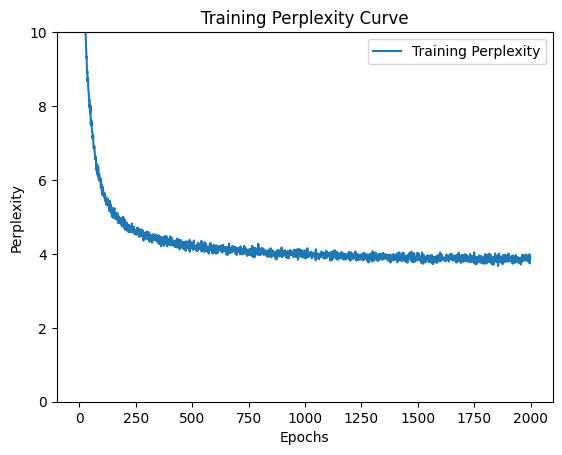

In [35]:
import matplotlib.pyplot as plt

epochs = len(all_losses)
plt.plot(range(epochs), all_losses, label='Training Perplexity')
plt.title('Training Perplexity Curve')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.ylim(0, 10)

# set the legend and display the plot
plt.legend()
plt.show()

## Task 2

In [37]:
decoder = torch.load('shakespeare.pt')

In [41]:
print(generate(decoder, prime_str='hj34s', cuda=args.cuda))

hj34s officer, could you do?

Nurse:
Why, in the chsignwell: being born peril of
that his speemertle, the


In [42]:
print(generate(decoder, prime_str='2sf 4', cuda=args.cuda))

2sf 4alled holy dinest world.

MERCUTIO:
What is a king and men when you too take you:
I would desire to 


In [43]:
print(generate(decoder, prime_str='  3  ', cuda=args.cuda))

  3  IV:
Whiling face! for comes are deceived;
Yet what is the wounds the hind in him of my honour how
Is


## Task 3

In [44]:
print(generate(decoder, prime_str='The', cuda=args.cuda))

The tale true vermelty distrous dedvengest so will, whose young confess to chance.

MENENIUS:
The king,


In [45]:
print(generate(decoder, prime_str='What is', cuda=args.cuda))

What is the word,
If it under my army before a power,
Which thinks o'er villain so dead with such a warm
Fa


In [46]:
print(generate(decoder, prime_str='Shall I give', cuda=args.cuda))

Shall I give me stands?
And I make had revenge his thirsting once,
That is like are a business counted worse;
Fo


In [47]:
print(generate(decoder, prime_str='X087hNYB BHN BYFVuhsdbs', cuda=args.cuda))

X087hNYB BHN BYFVuhsdbs I shed; and them
Hath the thrive in this: 'tis affairs them and
father to grow his counsellish.

AN
